In [2]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet50

In [13]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, json_path):
        self.img_dir = img_dir
        with open(json_path, "r") as f:
            data = json.load(f)

        # Словарь для быстрого доступа к изображениям по id
        self.images = {img["id"]: img for img in data["images"]}

        # Словарь для соответствия image_id -> список аннотаций
        self.annotations_by_image = {}
        for ann in data["annotations"]:
            image_id = ann["image_id"]
            if image_id not in self.annotations_by_image:
                self.annotations_by_image[image_id] = []
            self.annotations_by_image[image_id].append(ann)

        # Список всех image_id, для которых есть аннотации
        self.image_ids = list(self.annotations_by_image.keys())

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        print(f"Загружено {len(self.images)} изображений")
        print(f"Загружено {len(self.annotations_by_image)} изображений с аннотациями")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        # Получаем image_id
        image_id = self.image_ids[idx]

        # Получаем информацию об изображении
        img_info = self.images[image_id]
        img_path = f"{self.img_dir}/{img_info['file_name']}"

        # Загружаем изображение
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Не удалось загрузить изображение {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]

        # Преобразуем изображение
        img = self.transforms(img)

        # Получаем аннотации для этого изображения
        annotations = self.annotations_by_image[image_id]

        # Берем первую аннотацию
        # Если для одного изображения несколько аннотаций, можно решить, как их обрабатывать
        ann = annotations[0]

        # Извлекаем ключевые точки, игнорируя параметр видимости
        keypoints = ann["keypoints"]

        # Преобразуем в массив numpy, содержащий только x,y координаты (без видимости)
        kps = []
        for i in range(0, len(keypoints), 3):
            kps.append(keypoints[i])      # x
            kps.append(keypoints[i+1])    # y

        kps = np.array(kps, dtype=np.float32)

        # Масштабируем координаты для размера 224x224
        kps[::2] *= 224.0 / orig_w  # Adjust x coordinates
        kps[1::2] *= 224.0 / orig_h  # Adjust y coordinates

        return img, kps


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
from torch.utils.data import DataLoader, random_split

# Пути к данным
img_dir = r"/content/drive/MyDrive/court_keypoints/images/default"
json_path = r"/content/drive/MyDrive/court_keypoints/annotations/court_keypoints.json"

# Датасет
dataset = KeypointsDataset(img_dir, json_path)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)




Загружено 497 изображений
Загружено 497 изображений с аннотациями


In [6]:
print(len(train_loader))

56


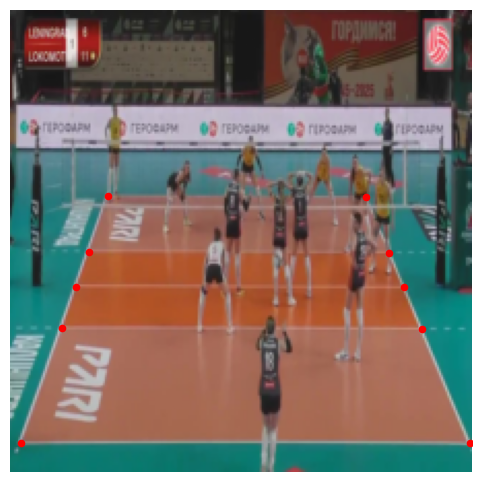

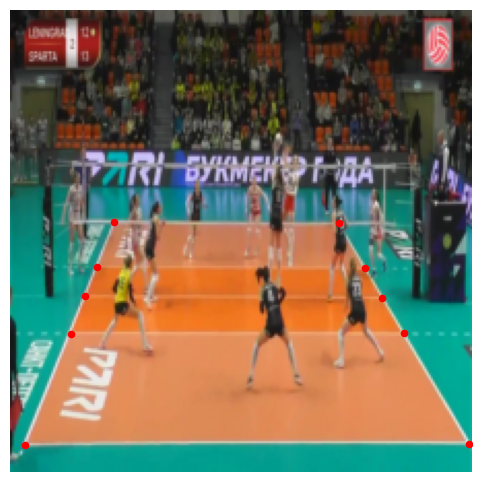

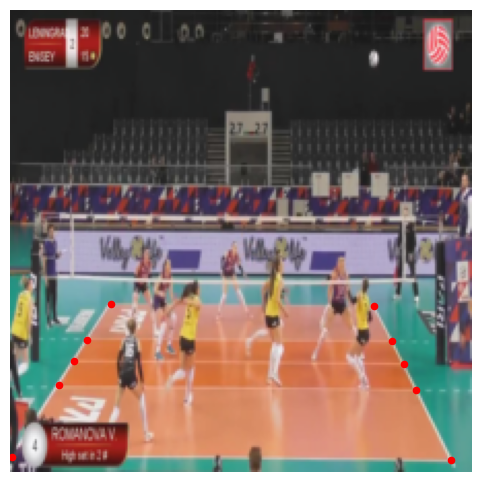

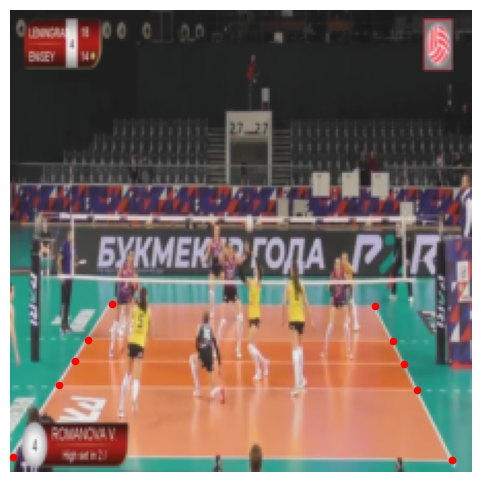

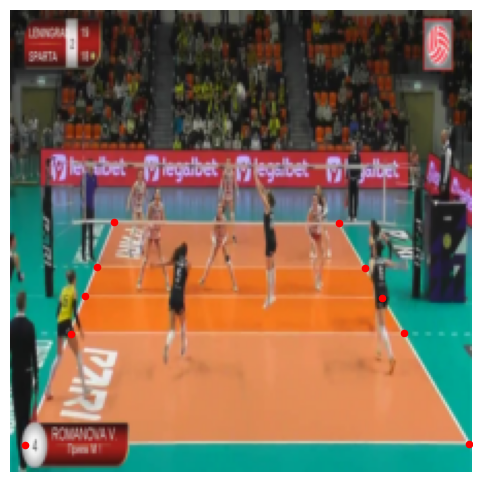

KeyboardInterrupt: 

In [15]:
import matplotlib.pyplot as plt
import torch

# Функция для обратной нормализации
def denormalize(img_tensor, mean, std):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)  # t = t * s + m
    return img_tensor

# Берем один батч
for img_batch, kps_batch in train_loader:
    img = img_batch[0]          # берем первое изображение из батча
    kps = kps_batch[0]           # и его ключевые точки

    # Разнормализуем изображение
    img = denormalize(img.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Переводим из [C, H, W] в [H, W, C]
    img = img.permute(1, 2, 0).numpy()

    # Ключевые точки
    kps = kps.detach().cpu().numpy()

    # Отображаем картинку
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    for i in range(0, len(kps), 2):
        x = kps[i]
        y = kps[i+1]
        plt.scatter(x, y, c='r', s=20)  # красные точки
    plt.axis('off')
    plt.show()


In [16]:
from torchvision import models, transforms
model = models.resnet50(pretrained=True)
model.fc =  torch.nn.Linear(model.fc.in_features, 10*2) # Replaces the last layer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


In [17]:
model = model.to(device)

In [18]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

tensor([[  3.7179, 209.3730, 218.4190, 209.5867,  28.5279, 157.8683, 186.8993,
         158.5269,  36.6337, 141.1815, 176.8218, 142.1111,  42.8933, 128.0617,
         168.8468, 129.0618,  52.2398, 107.9814, 157.0342, 108.9758]])
1080 1920


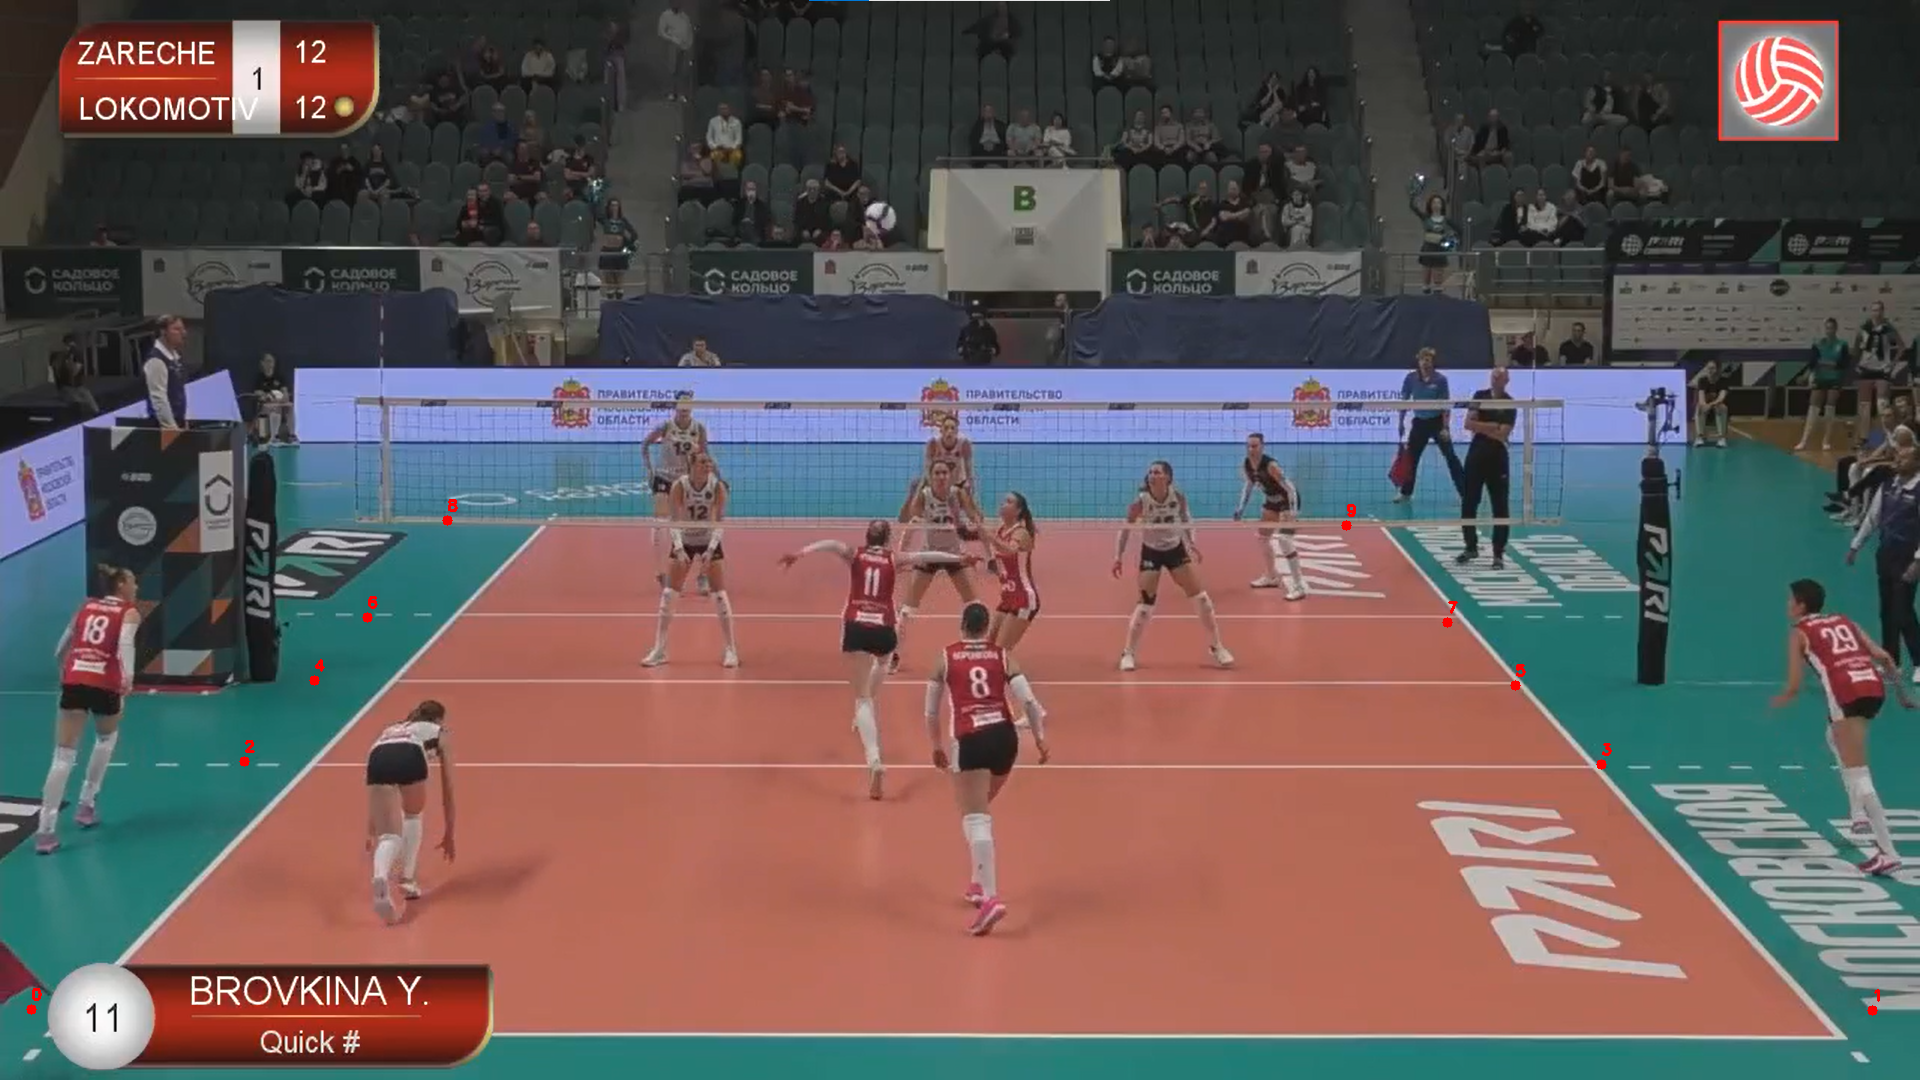

In [22]:
from google.colab.patches import cv2_imshow
class CourtLineDetector:
    def __init__(self, model_path):
        self.model = models.resnet50(pretrained=True)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10*2)
        self.model.load_state_dict(torch.load(model_path, map_location='cpu'))
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image):


            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_tensor = self.transform(image_rgb).unsqueeze(0)
            with torch.no_grad():
                outputs = self.model(image_tensor)
                print(outputs)
            keypoints = outputs.squeeze().cpu().numpy()
            original_h, original_w = image.shape[:2]
            print(original_h, original_w)
            keypoints[::2] *= original_w / 224.0
            keypoints[1::2] *= original_h / 224.0

            return keypoints

    def draw_keypoints(self, image, keypoints):
            # Plot keypoints on the image
        for i in range(0, len(keypoints), 2):
            x = int(keypoints[i])
            y = int(keypoints[i+1])
            cv2.putText(image, str(i//2), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
        return image
court_model_path = r"/content/model_last_epoch.pth"
court_line_detector = CourtLineDetector(court_model_path)

# Загрузка изображения из файла
image_path = r"/content/Снимок экрана 2025-04-27 152506.png"
image = cv2.imread(image_path)

# Проверка, что изображение успешно загружено
if image is None:
    raise ValueError(f"Не удалось загрузить изображение по пути {image_path}")

court_keypoints = court_line_detector.predict(image)
result_image = court_line_detector.draw_keypoints(image.copy(), court_keypoints)  # Используем copy, чтобы не изменять оригинал
cv2_imshow(result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import os

In [19]:
epochs = 160

for epoch in range(epochs):
    for i, (imgs, kps) in enumerate(train_loader):
        imgs = imgs.to(device)
        kps = kps.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, iter {i}, loss: {loss.item()}")

# Сохраняем модель после последней эпохи
save_path = "model_last_epoch.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Модель сохранена в файл: {save_path}")

Epoch 0, iter 0, loss: 20887.205078125
Epoch 0, iter 10, loss: 20991.177734375
Epoch 0, iter 20, loss: 20696.87890625
Epoch 0, iter 30, loss: 20423.033203125
Epoch 0, iter 40, loss: 19126.248046875
Epoch 0, iter 50, loss: 19637.625
Epoch 1, iter 0, loss: 18990.296875
Epoch 1, iter 10, loss: 18634.57421875
Epoch 1, iter 20, loss: 17618.365234375
Epoch 1, iter 30, loss: 17835.736328125
Epoch 1, iter 40, loss: 17389.818359375
Epoch 1, iter 50, loss: 17076.216796875
Epoch 2, iter 0, loss: 17686.19140625
Epoch 2, iter 10, loss: 16131.9658203125
Epoch 2, iter 20, loss: 14956.65625
Epoch 2, iter 30, loss: 15394.359375
Epoch 2, iter 40, loss: 14505.9658203125
Epoch 2, iter 50, loss: 15121.6669921875
Epoch 3, iter 0, loss: 13914.78125
Epoch 3, iter 10, loss: 13553.9501953125
Epoch 3, iter 20, loss: 13093.162109375
Epoch 3, iter 30, loss: 12346.98046875
Epoch 3, iter 40, loss: 12262.53515625
Epoch 3, iter 50, loss: 11764.6123046875
Epoch 4, iter 0, loss: 11582.82421875
Epoch 4, iter 10, loss: 10